Adar Saban - 313174120
Matav Vidal - 206508426 

In [1]:
import pandas as pd

def prepare_data(df: pd.DataFrame) -> pd.DataFrame:

    #Importing relevant libraries
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    from datetime import datetime
    from scipy.stats import chi2_contingency
    import matplotlib.ticker as ticker
    from sklearn.linear_model import LassoCV, Lasso, LinearRegression
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_squared_error
    from sklearn.preprocessing import StandardScaler
    import subprocess
    import sys
    from scipy.stats import linregress
    import warnings
    warnings.filterwarnings('ignore')


    #Defines the path to the CSV file containing the dataset.
    #Reads the CSV file into a Pandas DataFrame.
    #Prints the shape (number of rows and columns) of the DataFrame.    

    
    print(df.shape)

    #From this point we perform an analysis of the existing data.
    #We checked if there are duplicate rows in the data and deleted them.
    ### After each analysis and execution we make sure that there is indeed a change in the data ###.
   
    duplicates = df[df.duplicated()]
    df = df.drop_duplicates()
    print(df.shape)
    
    #Calculates the number of missing values in each column of the DataFrame.
    #Displays the number of missing entries per column.

    missing_values = df.isna().sum()
    print(missing_values)
    
    #We wanted to check what is the percentage of data in relation to each column in which data is missing.
    #Calculates the percentage of missing values in each column of the DataFrame.
    #Displays these percentages to understand the extent of missing data before cleaning the dataset.

    null_percent = df.isnull().mean() * 100
    print('Befor drop:\n',null_percent)
    
    #Remove from the model column if there is a manufacturer in the model name
    for i in range(len(df)):
            if df.iloc[i,0] in df.iloc[i,2]:
                df.iloc[i,2]= df.iloc[i,2].replace(df.iloc[i,0], '')
                
    models_with_multiple_manufacturers = df.groupby('model')['manufactor'].nunique().reset_index()
    models_with_multiple_manufacturers = models_with_multiple_manufacturers[models_with_multiple_manufacturers['manufactor'] > 1]
    models_with_multiple_manufacturers
    
    #We noticed that there was a problem with the manufacturer's name 'Lexus', 
    #we made a manual adjustment to the manufacturer's name and a number of problematic models.
    #There is a single number of lines in which the model appears in two manufacturers, minimal compared to the data.
    
    df['manufactor']=df['manufactor'].replace('Lexsus','לקסוס')
    df[df['model']=='לקסוס IS250']
    df[df['model']=='320']
    
    #Checking if there is a model with different names and converting to one name
    def change_if_same(value, substring, replacement):
        return replacement if substring in value else value
    df['model'] = df['model'].apply(change_if_same, args=('סיוויק', 'CIVIC'))
    df['model'] = np.where(np.isin(df['model'], ["JAZZ", "ג'אז", 'ג`אז']), 'JAZZ', df['model'])
    df['model'] = np.where(np.isin(df['model'], ['אקורד']), 'ACCORD', df['model'])
    
    #Checking what is the 'type' of each column.
    print(df.dtypes)
    
    #Convert columns to different types.
    df['manufactor'] = df['manufactor'].astype(str)
    df['Year'] = df['Year'].astype(int)
    df['model'] = df['model'].astype(str)
    df['Hand'] = df['Hand'].astype(int)
    df['capacity_Engine'] = df['capacity_Engine'].str.replace(',', '').astype(float)
    
    #Checking whether there are rows in which 'engine volume' has an Null value.
    #Filling in the empty values of the engine volume according to the type of model.
    #We decided to fill in the most common value depending on the vehicle model because engine volume does not change continuously.
    
    missing_indices = df[df['capacity_Engine'].isnull()].index
    for idx in missing_indices:
        model_value = df.loc[idx, 'model']
    # Find the mode of 'capacity_Engine' for the same 'model'
        model_mode = df[df['model'] == model_value]['capacity_Engine'].mode()
        if not model_mode.empty:
            df.loc[idx, 'capacity_Engine'] = model_mode.iloc[0]
        else:
        # If no model-specific mode is found, use the overall mode of the column
            overall_mode = df['capacity_Engine'].mode()
            if not overall_mode.empty:
                df.loc[idx, 'capacity_Engine'] = overall_mode.iloc[0]
        # Check if there are still any missing values

    missing_values_count = df['capacity_Engine'].isnull().sum()
    df['capacity_Engine'].isnull().sum()
    
    #Calculates the mode (most frequent value) of 'Engine_type' for each combination of 'Year', 'model', and 'manufactor' in the DataFrame.
    #Fill NaN values in Engine_Type column with the mode values of their respective groups
    #Fill remaining NaN values with the overall mode
    #We noticed that there are two engine types with the same meaning.
    mode_values = df.groupby(['Year', 'model', 'manufactor'])['Engine_type'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
    df['Engine_type'] = df['Engine_type'].fillna(mode_values)
    overall_mode = df['Engine_type'].mode()[0]
    df['Engine_type'] = df['Engine_type'].fillna(overall_mode)
    df['Engine_type'].value_counts()
    df['Engine_type']=df['Engine_type'].replace('היבריד', 'היברידי')
    df['Gear'] = df['Gear'].replace('אוטומט', 'אוטומטית')
    missing_values_count = df['Engine_type'].isnull().sum()    
    missing_values_count
    df['Gear'].unique()

    #that we performed a missing values check by percentage. 
    #'Gear' was less than a percentage of missing values, so we filled in the most common value
    
    df[df['Gear'].isna()]
    overall_Gear = df['Gear'].mode()[0]
    df['Gear'] = df['Gear'].fillna(overall_Gear)
    
    df['Area'].unique()

    locations = ['רעננה - כפר סבא', 'מושבים בשרון', 'רמת', 'נס ציונה - רחובות',
             'ראשל"צ והסביבה', 'פתח תקוה והסביבה', 'nan', 'חיפה וחוף הכרמל',
             'חולון - בת ים', 'ירושלים והסביבה', 'מושבים', 'כרמיאל והסביבה',
             'באר שבע והסביבה', 'גליל ועמקים', 'עכו - נהריה', 'בית שמש והסביבה',
             'גדרה יבנה והסביבה', 'אשדוד - אשקלון', 'טבריה והסביבה',
             'רמת גן - גבעתיים', 'קריות', 'תל אביב', 'ראש העין והסביבה',
             'עמק יזרעאל', 'נתניה והסביבה', 'בקעת אונו', 'גליל',
             'מודיעין והסביבה', 'פרדס', 'חדרה וישובי עמק חפר',
             'הוד השרון והסביבה', 'רמת השרון - הרצליה', 'None', 'חולון',
             'אזור השרון והסביבה', 'מושבים במרכז', 'קיסריה והסביבה',
             'מושבים בשפלה', 'רעננה', 'טבריה', 'אילת והערבה', 'זכרון - בנימינה',
             'רמלה - לוד', 'תל', 'הוד', 'עמק', 'ירושלים', 'יישובי השומרון',
             'פרדס חנה - כרכור', 'פתח', 'מודיעין', 'רמלה', 'ראשל"צ', 'נתניה',
             'מושבים בצפון', 'ראש', 'נס', 'חיפה', 'מושבים בדרום', 'רחובות']
    # Define the mapping function
    def map_location_to_region(location):
        regions = {
            'צפון': ['חיפה וחוף הכרמל', 'כרמיאל והסביבה', 'גליל ועמקים', 'עכו - נהריה',
                   'טבריה והסביבה', 'קריות', 'גליל', 'טבריה', 'זכרון - בנימינה',
                   'יישובי השומרון', 'פרדס חנה - כרכור', 'חדרה וישובי עמק חפר',
                   'מושבים בצפון'],
            'מרכז': ['רעננה - כפר סבא', 'מושבים בשרון', 'רמת', 'נס ציונה - רחובות',
                   'ראשל"צ והסביבה', 'פתח תקוה והסביבה', 'חולון - בת ים',
                   'ירושלים והסביבה', 'מושבים', 'גדרה יבנה והסביבה', 'רמת גן - גבעתיים',
                   'תל אביב', 'ראש העין והסביבה', 'נתניה והסביבה', 'בקעת אונו',
                   'מודיעין והסביבה', 'פרדס', 'הוד השרון והסביבה', 'רמת השרון - הרצליה',
                   'חולון', 'אזור השרון והסביבה', 'מושבים במרכז', 'קיסריה והסביבה',
                   'רעננה', 'רמלה - לוד', 'תל', 'הוד', 'עמק', 'ירושלים', 'פתח',
                   'מודיעין', 'רמלה', 'ראשל"צ', 'נתניה', 'רחובות'],
            'דרום': ['באר שבע והסביבה', 'אשדוד - אשקלון', 'אילת והערבה', 'מושבים בדרום'],
            'לא ידוע': ['nan', 'None']
    }
        for region, locations_in_region in regions.items():
            if location in locations_in_region:
                return region

        return 'מזרח'  # הנחה כללית

    # Assuming df already exists and has an 'Area' column
    df['Region'] = df['Area'].apply(map_location_to_region)
    cols_to_drop = ['Area']
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

    #We noticed that there are illogical values ​​of kilometers compared to a year. For example, in 1983 there is a car that traveled only 100 kilometers.
    #Let's start from the end of the code, we wanted to check if there is a linear relationship between the number of kilometers and the year of manufacture of the vehicle.
    #We realized that there is indeed a distinct statistical relationship.(p value is very small.)
    #We calculated the median value of kilometers by year .
    #We filled in the missing values according to the calculation
    
    df['Km'] = df['Km'].replace(['None', 'NaN', ''], np.nan)
    df['Km'] = df['Km'].replace(',', '', regex=True).astype(float)
    # Calculate median values of 'Km' by 'Year'
    median_values = df.groupby('Year')['Km'].median().round(0)
    # Fill NaN values with median values
    df['Km'] = df.apply(lambda row: int(median_values[row['Year']]) if np.isnan(row['Km']) else int(row['Km']), axis=1)
    # Convert 'Km' back to numeric
    df['Km'] = pd.to_numeric(df['Km'], errors='coerce')
    slope, intercept, r_value, p_value, std_err = linregress(df['Year'], df['Km'])
    print(f"Slope: {slope}, Intercept: {intercept}")
    print(f"R-squared: {r_value**2}")
    print(f"P-value: {p_value}")
    
    #Following the relationship we found between km and years,
    #we decided to perform a linear regression to change the exceptions in the best way
    #We predict the problematic values.
    # Prepare data for linear regression
    X = df[['Year']]
    y = df['Km']
    # Fit the linear regression model
    model = LinearRegression()
    model.fit(X, y)
    # Predict Km using the linear model
    df['Predicted_Km'] = model.predict(X)
    # Calculate residuals (errors)
    df['Residuals'] = df['Km'] - df['Predicted_Km']
    # Calculate standard deviation of residuals
    std_dev = df['Residuals'].std()
    # Define threshold for identifying outliers (e.g., 2 standard deviations)
    threshold = 2 * std_dev
    # Identify outliers
    df['Outlier'] = (np.abs(df['Residuals']) > threshold)
    # Save outliers to a separate DataFrame for adjustment
    outliers_df = df[df['Outlier']]
    # Adjust outliers by replacing them with predicted values from regression in the original DataFrame
    df.loc[outliers_df.index, 'Km'] = df.loc[outliers_df.index, 'Predicted_Km']
    # Drop temporary columns
    #df = df.drop(columns=['Predicted_Km', 'Residuals', 'Outlier'])
    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.scatter(df['Year'], df['Km'], color='blue', label='Original Km')
    plt.scatter(outliers_df['Year'], outliers_df['Km'], color='red', label='Outliers', marker='x')
    plt.plot(X, model.predict(X), color='red', linewidth=2, label='Regression Line')
    plt.xlabel('Year')
    plt.ylabel('Km')
    plt.title('Km vs Year with Linear Regression')
    plt.legend()
    plt.grid(True)
    plt.ticklabel_format(style='plain', axis='y')  # Set y-axis to plain format
    plt.show()
    
    #Checking whether all the exceptions have changed
    df[df['Outlier']==True] 
    
    #delete the columns that are not relevant as a way to continue the project.
    cols_to_drop = ['Predicted_Km', 'Residuals', 'Outlier','Pic_num','Supply_score','Test','Prev_ownership','Curr_ownership','Color','Description','Repub_date','Cre_date']
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])
    
    #Checking whether the data contains missing values.
    null_percent = df.isnull().mean() * 100
    print('Before drop:\n',null_percent)
    
    #Hit map to check correlation for the selected objects.
    correlation_matrix = df.corr()
    correlation_matrix
    plt.figure(figsize=(8,8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix Heatmap')
    plt.show()
    df
    
    #We wanted to check if there is a statistical relationship
    #between the number of hands, and the price of the vehicle.
    #You can see from the graph that there is a relationship between hand and price.
    #When the number of hands increases, the price of the vehicle becomes smaller.
    
    print(df.columns)
    if 'Hand' in df.columns and 'Price' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Hand', y='Price', data=df)
        plt.xlabel('Hand')
        plt.ylabel('Price')
        plt.title('Box Plot of Price by Hand')
        plt.grid(True)
        plt.show()
    else:
        print("One or both of the columns 'Hand' and 'Price' do not exist in the DataFrame.")
    
    #We performed another test using linear regression. The test showed that there is indeed a strong relationship between price and the amount of hands. 
    #It can also be seen in the graph and in the value of P.
    X = df[['Hand']]  # Change to 2D array
    y = df['Price']
    model = LinearRegression()
    model.fit(X, y)
    # Step 2: Get the slope, intercept, R-squared, and p-value
    slope, intercept, r_value, p_value, std_err = linregress(df['Hand'], df['Price'])
    # Print the results
    print(f"Slope: {slope}")
    print(f"Intercept: {intercept}")
    print(f"R-squared: {r_value**2}")
    print(f"P-value: {p_value:.10e}")
    # Determine if the relationship is significant
    if p_value < 0.05:
        print("There is a significant relationship between Hand and Price.")
    else:
        print("There is no significant relationship between Hand and Price.")
    # Step 3: Plot the data and the regression line
    plt.scatter(df['Hand'], df['Price'], color='blue', label='Data Points')
    plt.plot(df['Hand'], model.predict(X), color='red', linewidth=2, label='Regression Line')
    plt.xlabel('Hand')
    plt.ylabel('Price')
    plt.title('Hand vs Price')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    #We wanted to check if there is a statistical relationship
    #between the year,and the price of the vehicle.
    print(df.columns)
    if 'Year' in df.columns and 'Price' in df.columns:
        plt.figure(figsize=(14, 6))
        sns.boxplot(x='Year', y='Price', data=df)
        plt.xlabel('Year')
        plt.ylabel('Price')
        plt.title('Box Plot of Price by Year')
        plt.grid(True)
        plt.show()
    else:
        print("One or both of the columns 'Year' and 'Price' do not exist in the DataFrame.")
    
    #It is difficult to understand from the graph of the box plot whether there is a relationship, 
    #so we ran a regression model again to check for a relationship.  the p value is very smal(0.05>p), so there is a relationship.
    #The longer the year of production, the higher the price of the vehicle
    X = df[['Year']]  # Change to 2D array
    y = df['Price']
    model = LinearRegression()
    model.fit(X, y)
    # Step 2: Get the slope, intercept, R-squared, and p-value
    slope, intercept, r_value, p_value, std_err = linregress(df['Year'], df['Price'])
    # Print the results
    print(f"Slope: {slope}")
    print(f"Intercept: {intercept}")
    print(f"R-squared: {r_value**2}")
    print(f"P-value: {p_value:.10e}")
    # Determine if the relationship is significant
    if p_value < 0.05:
        print("There is a significant relationship between Year and Price.")
    else:
        print("There is no significant relationship between Year and Price.")
    # Step 3: Plot the data and the regression line
    plt.scatter(df['Year'], df['Price'], color='blue', label='Data Points')
    plt.plot(df['Year'], model.predict(X), color='red', linewidth=2, label='Regression Line')
    plt.xlabel('Year')
    plt.ylabel('Price')
    plt.title('Year vs Price')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    #Checking how the engine volume affects the price.
    #First we checked what the most common engine volume values are.
    counts = df['capacity_Engine'].value_counts()
    counts.head(10)
    
    #We used boxplot to try to understand how the engine volume affects the price.
    top_values = df['capacity_Engine'].value_counts().nlargest(7).index
    # Step 2: Filter data and calculate median price
    filtered_df = df[df['capacity_Engine'].isin(top_values)]
    median_prices = filtered_df.groupby(['capacity_Engine','Year'])['Price'].median().reset_index()
    # Sort top_values by capacity_Engine
    top_values_sorted = sorted(top_values, key=float)  # Sort as floats if they are numeric strings
    # Step 3: Create box plot
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='capacity_Engine', y='Price', data=median_prices, order=top_values_sorted)
    plt.xlabel('capacity_Engine')
    plt.ylabel('Price')
    plt.title('Box Plot of Price by Capacity Engine (Top 7)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()
    
    #It is difficult to understand from the graph what is the effect of engine volume on the price of the vehicle.
    #In addition, we noticed that the price range of a 2000 displacement engine is less than the price range of a 1500 displacement engine, which does not seem normal.
    #We assumed it was because the prices of vehicles larger than 100,000 are not included in the data.
    top_5_engines = df['capacity_Engine'].value_counts().nlargest(5).index.tolist()
    print(f'Top 5 Popular Capacity Engines: {top_5_engines}')
    # Filtering the data to contain only the five popular volumes
    filtered_df = df[df['capacity_Engine'].isin(top_5_engines)]
    # Receiving quantities by year and engine volume
    capacity_by_year = filtered_df.groupby(['Year', 'capacity_Engine']).size().reset_index(name='Count')
    # Function to find the difference between the quantities
    def calculate_year_diff(group):
        if len(group) < 5:
            return np.nan
        sorted_counts = sorted(group['Count'])
        diffs = [abs(sorted_counts[i] - sorted_counts[i + 1]) for i in range(len(sorted_counts) - 1)]
        return sum(diffs) / len(diffs) if diffs else np.nan
    # Calculation of the difference by year
    year_diffs = capacity_by_year.groupby('Year').apply(calculate_year_diff).reset_index(name='Diff')
    # Finding the three years that are closest in quantity
    closest_years = year_diffs.dropna().nsmallest(3, 'Diff')['Year'].tolist()
    # Guaranteed at least 20 data in each selected year
    def check_min_count(year, min_count=20):
        return len(df[df['Year'] == year]) >= min_count
    # Cutting the data according to the years found and performing groupby
    closest_years = [year for year in closest_years if check_min_count(year)]
    print(f'Closest Years with at least 20 entries: {closest_years}')
    final_filtered_df = df[df['Year'].isin(closest_years)]
    grouped_filtered_df = final_filtered_df.groupby(['Year', 'capacity_Engine']).size().reset_index(name='Count')
    print(grouped_filtered_df)
    
    #Here we see that there is some kind of upward trend as the engine volume is large so the price increases.
    #We wanted to see if the same trend exists between each year according to the popular engine volumes.
    # Filtering the data according to the years and volumes we found
    filtered_df = df[(df['Year'].isin(closest_years)) & (df['capacity_Engine'].isin(top_5_engines))]
    # Show a preview of the filtered data
    print(filtered_df[['Year', 'capacity_Engine', 'Price']].head())

    plt.figure(figsize=(14, 7))
    sns.boxplot(data=filtered_df, x='capacity_Engine', y='Price', hue='Year', palette='tab10')
    plt.title('Box Plot of Price vs. Capacity Engine by Year')
    plt.xlabel('Capacity Engine')
    plt.ylabel('Price')
    plt.legend(title='Year')
    plt.grid(True)
    plt.show()
    #Another graph and regression model to illustrate the existing trend.
    plt.figure(figsize=(14, 7))
    for year in closest_years:
        year_data = filtered_df[filtered_df['Year'] == year]
        X = year_data[['capacity_Engine']]
        y = year_data['Price']
        model = LinearRegression()
        model.fit(X, y)
        y_pred = model.predict(X)
        plt.scatter(X, y, label=f'Year {year}')
        plt.plot(X, y_pred, linewidth=2)
        plt.title('Linear Regression of Price vs. Engine Capacity by Year')
        plt.xlabel('Capacity Engine')
        plt.ylabel('Price')
        plt.legend()
    plt.grid(True)
    plt.show()
    #chi square test for categorical variables
    #Arrange the cities into 3 regions.
    variables = ['manufactor', 'Gear', 'Engine_type', 'Region']

    plt.figure(figsize=(15, 10))
    for i, var in enumerate(variables, 1):
        plt.subplot(3, 2, i)
        sns.boxplot(x=var, y='Price', data=df)
        plt.title(f'Boxplot of {var} vs Price')
        plt.xlabel(var)
        plt.ylabel('Price')

    plt.tight_layout()
    plt.show()
    return df
    
    #We performed a chi square test on the featuers we chose to verify that there is indeed a relationship between the variables and the price.
    variables = ['manufactor', 'model', 'Gear', 'Engine_type', 'Region']

    # Function to perform Chi-Square test
    def chi_square_test(variable):
        # Create a contingency table
        contingency_table = pd.crosstab(df[variable], df['Price'])

        # Perform Chi-Square test
        chi2, p, dof, ex = chi2_contingency(contingency_table)

        return chi2, p

    # Perform tests and print results
    for var in variables:
        chi2, p = chi_square_test(var)
        print(f"{var}: Chi2 = {chi2:.2f}, p-value = {p:.2e} - {'Significant relationship with Price' if p < 0.05 else 'No significant relationship with Price'}")
    #result of chi test:
#     manufactor: Chi2 = 5543.24, p-value = 3.66e-14 - Significant relationship with Price
#     model: Chi2 = 54321.67, p-value = 9.81e-01 - No significant relationship with Price
#     Gear: Chi2 = 745.13, p-value = 1.00e+00 - No significant relationship with Price
#     Engine_type: Chi2 = 1005.21, p-value = 1.26e-01 - No significant relationship with Price
#     Region: Chi2 = 940.54, p-value = 1.19e-05 - Significant relationship with Price

    #According to the boxplot graph between manufacturer and price, we saw that there is a difference between Expected values, but not a significant difference.
    #Since in Data the maximum price for a car is 100 thousand which hurt the manufacturers whose car prices are higher. which caused the test to be incorrect.
    
    #החלטנו להוציא את הרכבים בשנים האלה לאחר בדיקה שבה גילינו כי יש סהכ 12 רכבים כאלה בדאטה 


(1500, 20)
(1372, 20)
manufactor            0
Year                  0
model                 0
Hand                  0
Gear                  1
capacity_Engine      26
Engine_type           5
Prev_ownership      712
Curr_ownership      712
Area                134
City                  0
Price                 0
Pic_num              24
Cre_date              0
Repub_date            0
Description           0
Color               699
Km                   74
Test               1267
Supply_score       1037
dtype: int64
Befor drop:
 manufactor          0.000000
Year                0.000000
model               0.000000
Hand                0.000000
Gear                0.072886
capacity_Engine     1.895044
Engine_type         0.364431
Prev_ownership     51.895044
Curr_ownership     51.895044
Area                9.766764
City                0.000000
Price               0.000000
Pic_num             1.749271
Cre_date            0.000000
Repub_date          0.000000
Description         0.000000
Color   

C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
<ipython-input-1-372008c0e2d8>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['manufactor']=df['manufactor'].replace('Lexsus','לקסוס')
<ipython-input-1-372008c0e2d8>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

Slope: -7947.166724862294, Intercept: 16129764.78474264
R-squared: 0.13720990133935634
P-value: 7.20890164195963e-46


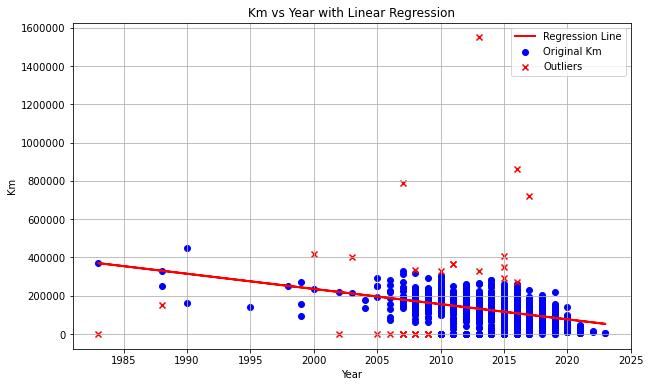

Before drop:
 manufactor         0.0
Year               0.0
model              0.0
Hand               0.0
Gear               0.0
capacity_Engine    0.0
Engine_type        0.0
City               0.0
Price              0.0
Km                 0.0
Region             0.0
dtype: float64


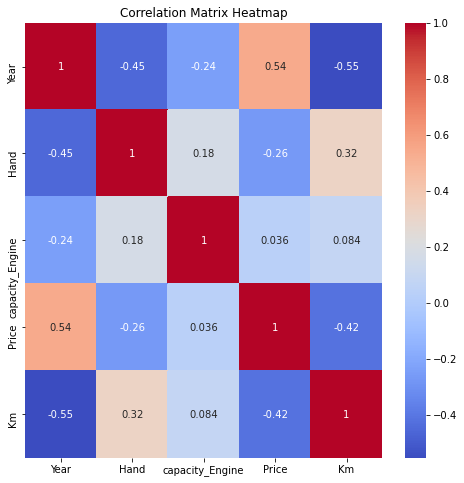

Index(['manufactor', 'Year', 'model', 'Hand', 'Gear', 'capacity_Engine',
       'Engine_type', 'City', 'Price', 'Km', 'Region'],
      dtype='object')


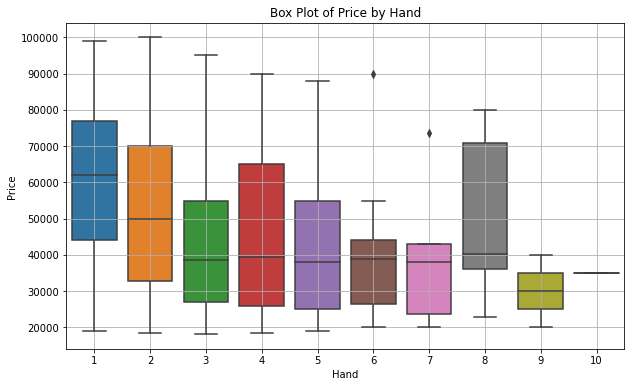

Slope: -4665.390336983368
Intercept: 61956.920237109276
R-squared: 0.0692041514207773
P-value: 3.7546219395e-23
There is a significant relationship between Hand and Price.


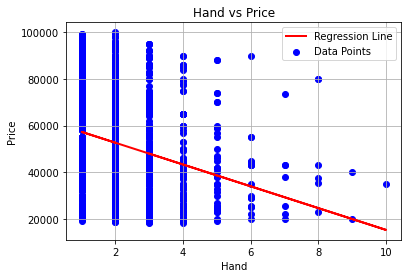

Index(['manufactor', 'Year', 'model', 'Hand', 'Gear', 'capacity_Engine',
       'Engine_type', 'City', 'Price', 'Km', 'Region'],
      dtype='object')


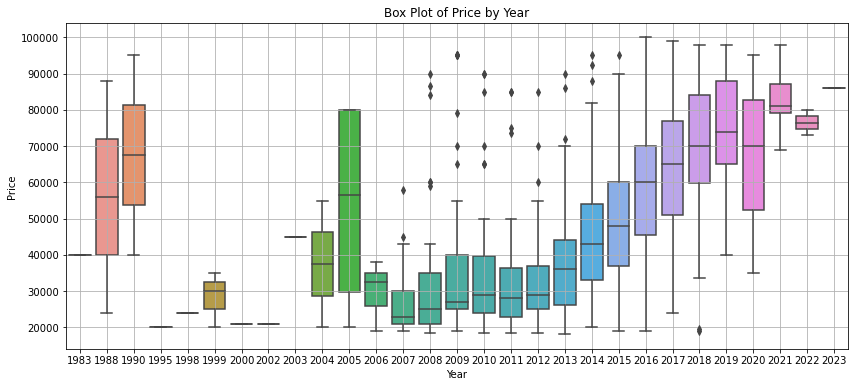

Slope: 3080.2428941254425
Intercept: -6153542.511261338
R-squared: 0.2953769999801909
P-value: 2.8052960511e-106
There is a significant relationship between Year and Price.


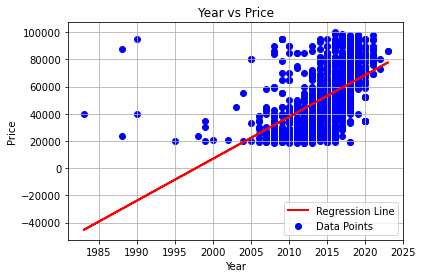

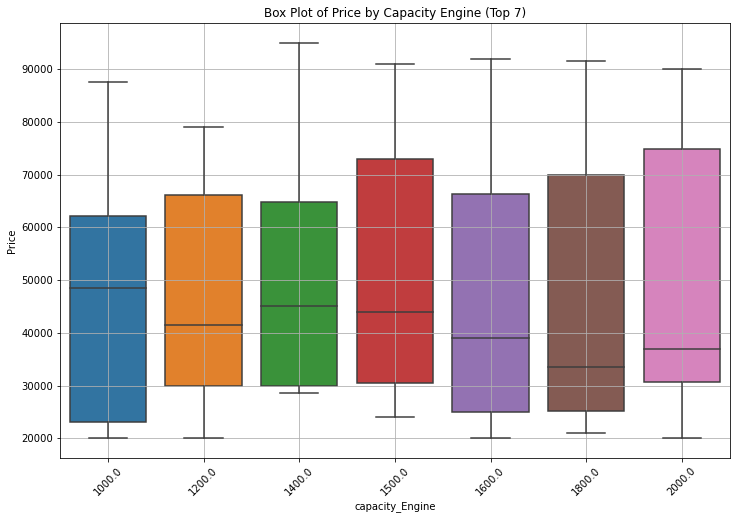

Top 5 Popular Capacity Engines: [1600.0, 1400.0, 1200.0, 2000.0, 1800.0]
Closest Years with at least 20 entries: [2011, 2010, 2019]
    Year  capacity_Engine  Count
0   2010           1197.0      1
1   2010           1200.0      4
2   2010           1300.0      2
3   2010           1400.0      3
4   2010           1450.0      1
..   ...              ...    ...
56  2019           1600.0     13
57  2019           1800.0      2
58  2019           2000.0      2
59  2019           2500.0      1
60  2019           4500.0     12

[61 rows x 3 columns]
    Year  capacity_Engine    Price
24  2011           1600.0  32000.0
36  2011           1800.0  30000.0
74  2011           1200.0  45000.0
86  2011           1200.0  22000.0
92  2019           1600.0  95000.0


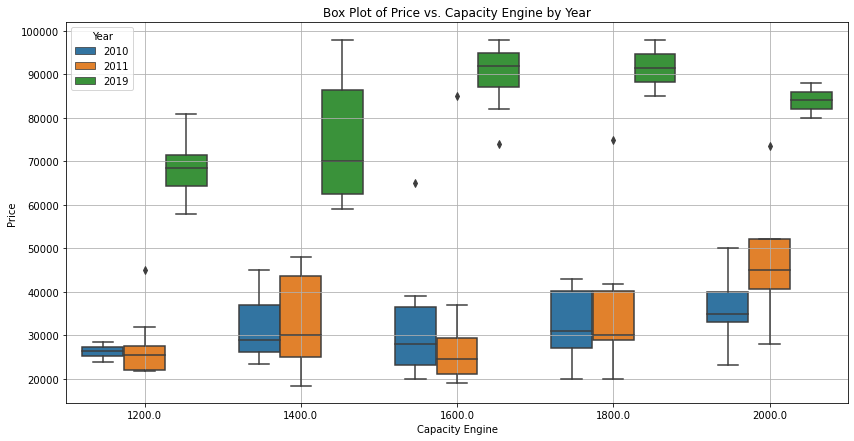

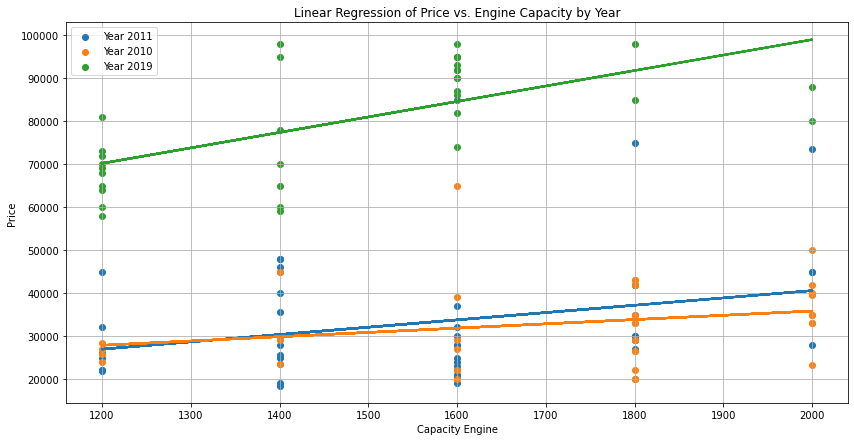

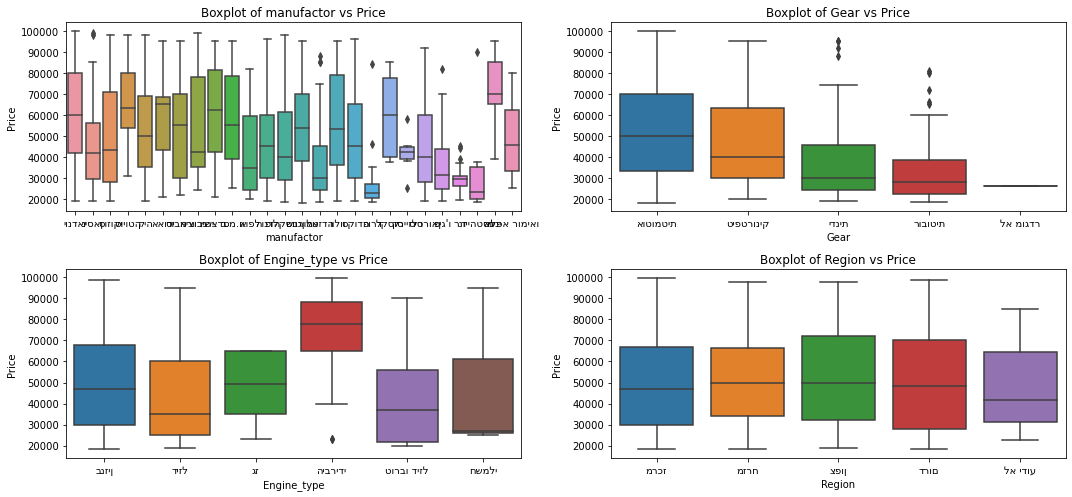

In [2]:
df=pd.read_csv('dataset.csv')
df=prepare_data(df)
df.to_csv('output_finish.csv', index=False)


From this point we work on the prediction model.
We performed a chi square test on the featuers we chose to verify that there is indeed a relationship between the variables and the price.

Model

In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Reading date
df = df.dropna(subset=['Price'])

# Saving the original index
df['original_index'] = df.index

#selected featuers
features = ['manufactor', 'model', 'Year', 'capacity_Engine', 'Engine_type']
X = df[features]
y = df['Price']

# Coding categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Keeping the original column names
column_names = X_encoded.columns

# Normalize properties
scaler = StandardScaler()
X_encoded = scaler.fit_transform(X_encoded)

# Split the data
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X_encoded, y, df['original_index'], test_size=0.2, random_state=42)

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    return rmse, predictions

# Elastic Net
elastic_net = ElasticNet(positive=True)
param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0],
    'l1_ratio': [0.1, 0.5, 0.7, 1.0]
}
grid_search = GridSearchCV(elastic_net, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_elastic_net = grid_search.best_estimator_

# Display the selected hyperparameters
print(f"Best alpha: {best_elastic_net.alpha}")
print(f"Best l1_ratio: {best_elastic_net.l1_ratio}")

# Predicting the values
y_pred = best_elastic_net.predict(X_test)

#The predictions are only positive because it is about price
y_pred = np.maximum(y_pred, 0)


# Cross validation with 10 parts on the data
cv_scores_cleaned = cross_val_score(best_elastic_net, X_encoded, y, cv=10, scoring='neg_mean_squared_error')
cv_rmse_scores_cleaned = np.sqrt(-cv_scores_cleaned)

# Calculation of the effect of the original characteristics
coefs = best_elastic_net.coef_
coefs_dict = dict(zip(column_names, coefs))

# Calculation of the effect for the original columns
feature_importance = {}
for feature in features:
    impact_sum = sum(value for key, value in coefs_dict.items() if key.startswith(feature))
    feature_importance[feature] = impact_sum

# הוספת כיוון ההשפעה
feature_impact = {feature: 'חיובי' if importance > 0 else 'שלילי' for feature, importance in feature_importance.items()}

#disalpy results
for feature, impact in feature_impact.items():
    print(f'Feature: {feature}, Impact: {impact}, Importance: {feature_importance[feature]:.4f}')

print(f'Elastic Net Cross-validated RMSE on cleaned data: {cv_rmse_scores_cleaned.mean():.4f} ± {cv_rmse_scores_cleaned.std():.4f}')

print(y_pred.min())



Best alpha: 1.0
Best l1_ratio: 0.7
Feature: manufactor, Impact: חיובי, Importance: 13549.0668
Feature: model, Impact: חיובי, Importance: 110957.9278
Feature: Year, Impact: חיובי, Importance: 10300.0325
Feature: capacity_Engine, Impact: חיובי, Importance: 790.5161
Feature: Engine_type, Impact: חיובי, Importance: 1019.3003
Elastic Net Cross-validated RMSE on cleaned data: 15527.6088 ± 1167.2830
24503.1314282296
